# Evasion Attacks and Defenses on Hugging Face Models using ART - Part 2 Defense

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers

from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.defences.trainer import AdversarialTrainerMadryPGD
from art.utils import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # <-- use the GPU if available, otherwise the CPU (slow!)
# In case you work on a Mac with Apple Silicon or AMD GPU you can use 'mps' device.
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')


## Dataset 


In [2]:
# We will use a small subset of the CIFAR-10 dataset.
# For test and debugging runs you can even reduce this parameters to avoid long calculation times.
SAMPLES_PER_CLASS = 200



(x_train, y_train), (x_test, y_test), _, _ = load_dataset('cifar10')
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)

x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
y_test = np.argmax(y_test, axis=1)

classes = np.unique(y_train)


x_subset = []
y_subset = []


for c in classes:
    indices = y_train == c
    x_subset.append(x_train[indices][:SAMPLES_PER_CLASS])
    y_subset.append(y_train[indices][:SAMPLES_PER_CLASS])


x_subset = np.concatenate(x_subset)
y_subset = np.concatenate(y_subset)


print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

x_subset: float32 (1000, 3, 32, 32)
y_subset: int64 (1000,)


In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [4]:
# Create state_dicts directory for saving models

if not os.path.isdir('./state_dicts'):
    os.mkdir('./state_dicts')

Set model 

# PyTorch Image Models (timm)

PyTorch Image Models (timm) is a poular repository for SOTA implementations of image models and Hugging Face is hosting many of the models and weights.

We can use timm models here with the same wrapper.

To run this part of the notebook we need to install the timm library

`pip install timm`

This notebook was ran with timm==0.9.8

In [5]:
import timm

In [6]:
# Start with a small ResNet Model
MODEL_NAME = 'resnet18.a1_in1k'
# Later use a bigger one: 
#MODEL_NAME = 'resnet50.a1_in1k'

In [7]:

model = timm.create_model(MODEL_NAME, pretrained=True)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

timm_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer,
    clip_values=(0, 1),
    processor=upsampler
)

In [8]:
limit=2000
#timm_model.fit(x_subset[:limit], y_subset[:limit], nb_epochs=1)
timm_model.fit(x_subset, y_subset, nb_epochs=10)

KeyboardInterrupt: 

Takes approx. 1 min / epoch for ResNet18 on MacBook Pro...


In [9]:
output = timm_model.predict(x_test)
preds = np.argmax(output, axis=1)

In [10]:
timm_acc = np.mean(preds == y_test)
print('accuracy:', timm_acc)

accuracy: 1.0


## Adversarial Training with ART

In [11]:
trainer_resnet = AdversarialTrainerMadryPGD(
    classifier=timm_model,
    nb_epochs=15,
    eps=8/255,
    eps_step=1/255,
    max_iter=10
)

In [12]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/timm_%s_cifar_robust_model.pt' % MODEL_NAME
if os.path.isfile(model_checkpoint_path):
    trainer_resnet.classifier.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    trainer_resnet.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(trainer_resnet.classifier.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

saved model checkpoint


about 12 min per epoch (MacBookPro M1)

In [13]:
outputs = trainer_resnet.classifier.predict(x_subset)
clean_preds = np.argmax(outputs, axis=1)
clean_acc = np.mean(clean_preds == y_subset)
print('ResNet clean accuracy:', clean_acc)

ResNet clean accuracy: 0.726


approx. 90 s

In [14]:
# load adversarial samples if they already exist, otherwise generate them

adv_samples_path = './state_dicts/x_adv_robust.timm_%s_npy' % MODEL_NAME
if os.path.isfile(adv_samples_path):
    x_adv = np.load(adv_samples_path)
else:
    attacker = ProjectedGradientDescentPyTorch(trainer_resnet.classifier, eps=8/255, eps_step=1/255)
    x_adv = attacker.generate(x_subset)
    np.save(adv_samples_path, x_adv)

outputs = trainer_resnet.classifier.predict(x_adv)
adv_preds = np.argmax(outputs, axis=1)
adv_acc = np.mean(adv_preds == y_subset)
print('%s adversarial accuracy:' % MODEL_NAME, adv_acc)

PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

resnet18.a1_in1k adversarial accuracy: 0.115


### Your task
You make an observation here, which is well known in AI security: Your model suffers from being made robust... You all had basic classes in Machine Learning. Please, analyze the following aspects:
- Visualize the images that are correcly classified and those that are wrong classified
- Vary key hyperparameters (at least manually or a simple grid search), you can choose a hyperparameter tuning framework if you are familiar with it. 
- Vary the parameters of the adversarial training (parameters of class AdversarialTrainerMadryPGD, e.g. eps). Do you see an influence?
- Try with ResNet50, do you see a difference? (You will need GPUs and some time for that).

General hints:
- Consider cross-reading Madry's paper from the lecutre. 
- Work in teams

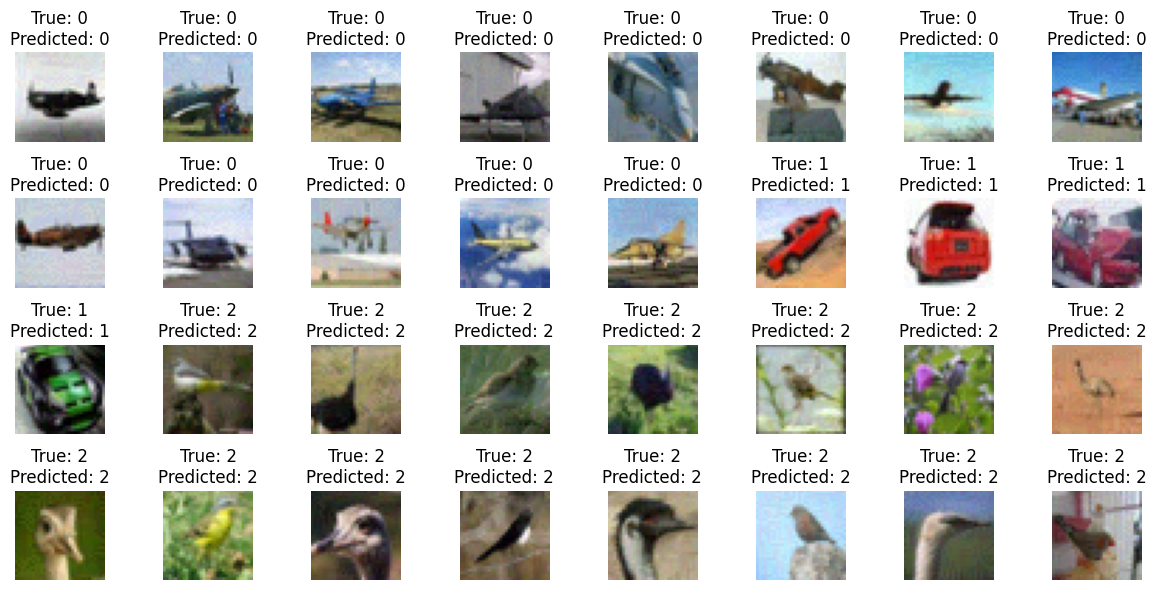

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_images(images, true_labels, predicted_labels):
    fig, axs = plt.subplots(num_rows,num_per_row, figsize=(12, 6))
    axs = axs.flatten()

    for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
        image = np.transpose(image, (1, 2, 0))
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f'True: {true_label}\nPredicted: {predicted_label}')

    plt.tight_layout()
    plt.show()


correctly_classified_images = x_adv[adv_preds == y_subset]
correctly_classified_labels = y_subset[adv_preds == y_subset]
correctly_classified_predicted_labels = adv_preds[adv_preds == y_subset]

wrongly_classified_images = x_adv[adv_preds != y_subset]
wrongly_classified_labels = y_subset[adv_preds != y_subset]
wrongly_classified_predicted_labels = adv_preds[adv_preds != y_subset]

num_per_row = 8
num_rows = 4

# Visualize correctly classified images
visualize_images(correctly_classified_images[:num_rows*num_per_row], correctly_classified_labels[:num_rows*num_per_row], correctly_classified_predicted_labels[:num_rows*num_per_row])

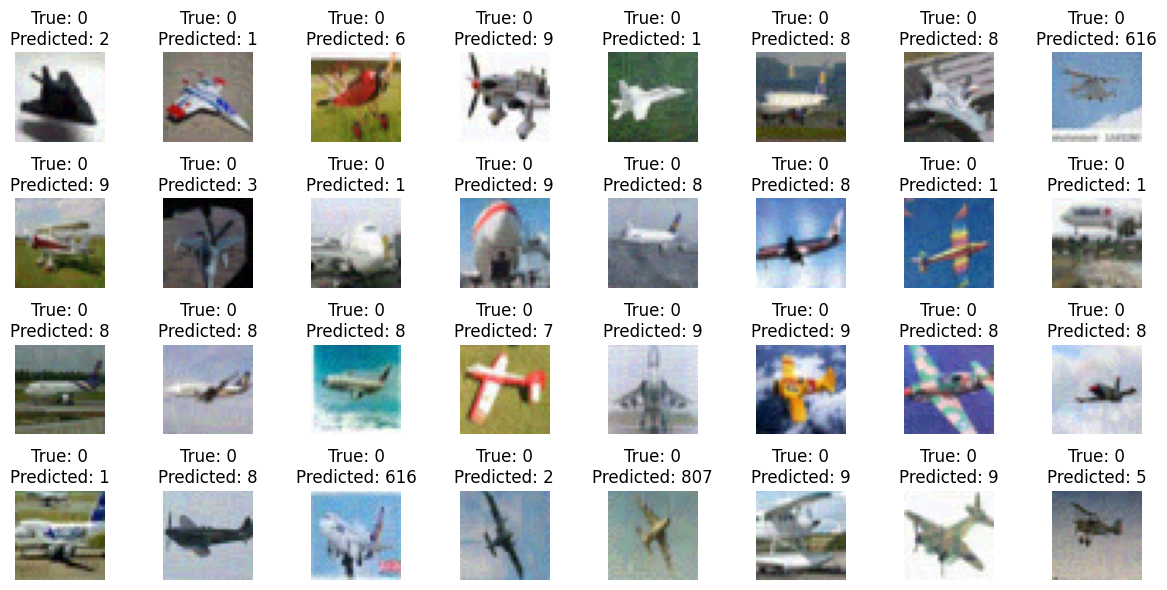

In [44]:
visualize_images(wrongly_classified_images[:num_rows*num_per_row], wrongly_classified_labels[:num_rows*num_per_row], wrongly_classified_predicted_labels[:num_rows*num_per_row])

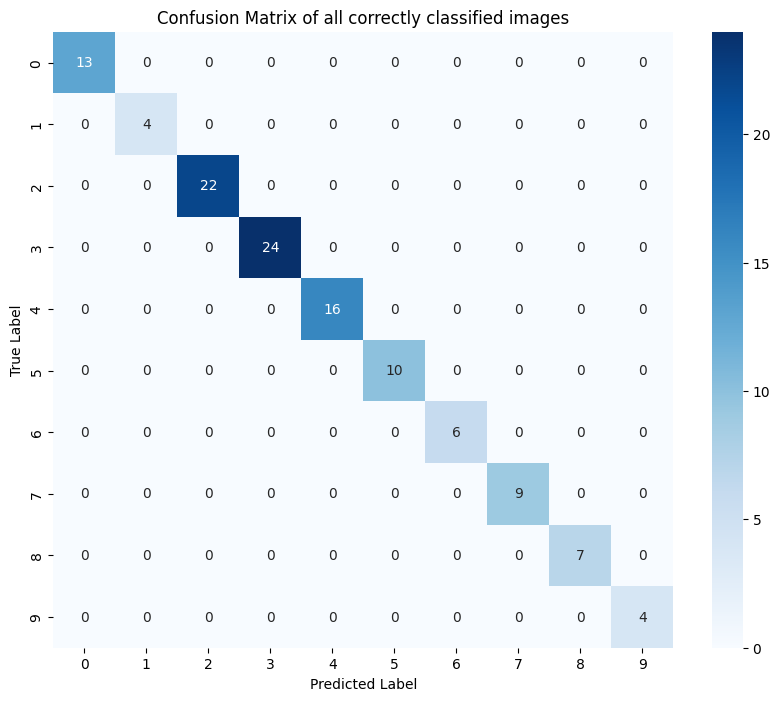

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(correctly_classified_labels, correctly_classified_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of all correctly classified images')
plt.show()


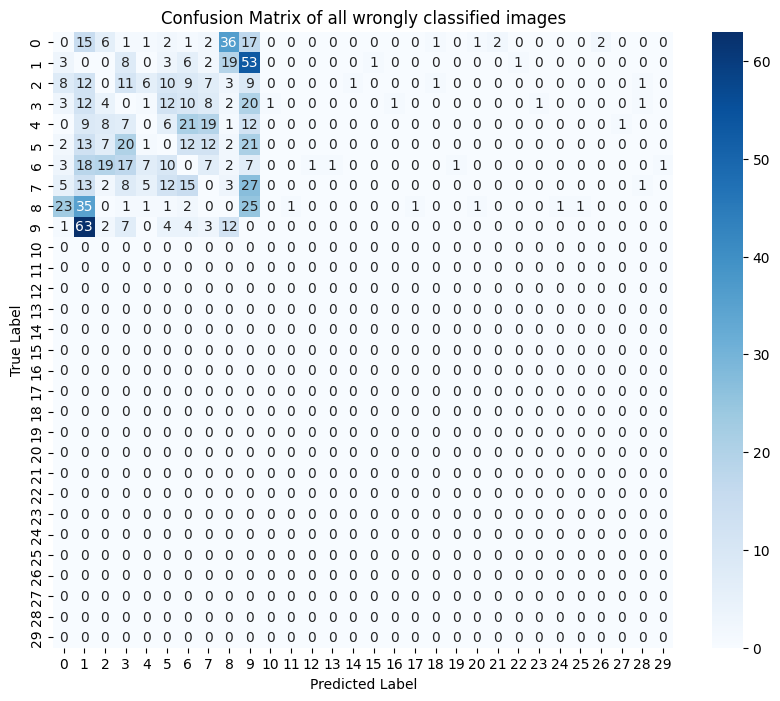

In [58]:
confusion_mat = confusion_matrix(wrongly_classified_labels, wrongly_classified_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of all wrongly classified images')
plt.show()

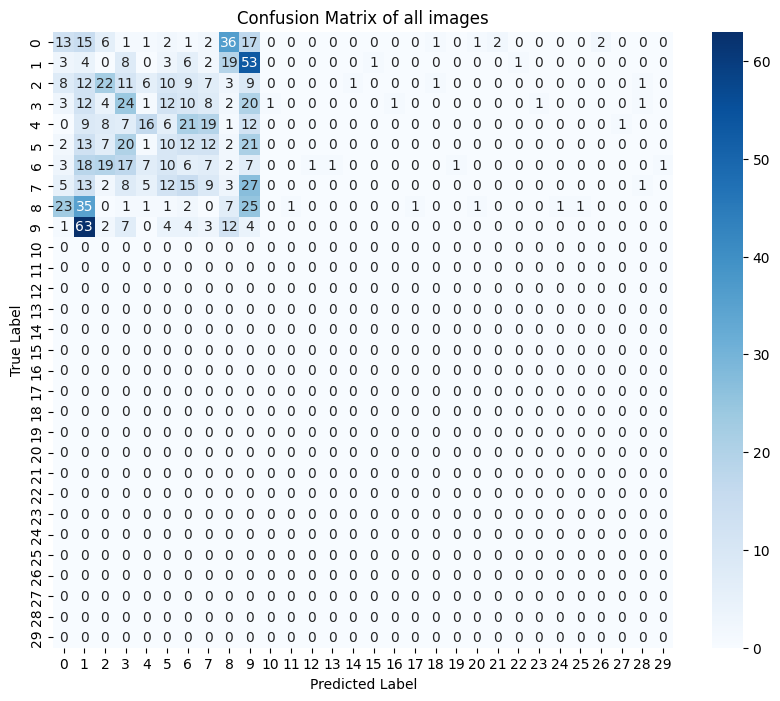

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(y_subset, adv_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of all images')
plt.show()


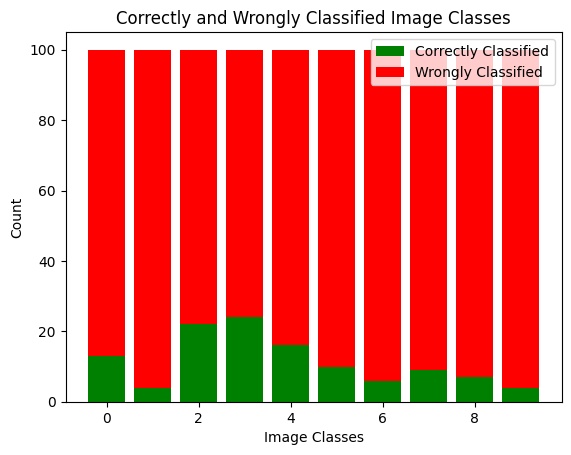

In [47]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
correct_counts = correctly_classified_images.__len__()
wrong_counts = wrongly_classified_images.__len__()

fig, ax = plt.subplots()

for i in range(10):
    ax.bar(i, np.count_nonzero(correctly_classified_labels == i), color='green')
    ax.bar(i, np.count_nonzero(wrongly_classified_labels == i), bottom=np.count_nonzero(correctly_classified_labels == i), color='red')

ax.bar(0, 0, color='green', label='Correctly Classified')
ax.bar(0, 0, color='red', label='Wrongly Classified')

ax.set_xlabel('Image Classes')
ax.set_ylabel('Count')
ax.set_title('Correctly and Wrongly Classified Image Classes')

ax.legend()

plt.show()
